In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import plotly.offline as ply
import plotly.graph_objs as go

import datetime

import scipy.stats as stats
ply.init_notebook_mode(connected=True)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [60]:
passengers = pd.read_csv('train.csv', index_col='PassengerId')
passengers.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## clean

### make categorical data dummies

In [61]:
passengers = pd.get_dummies(
    passengers, 
    columns=['Pclass','Sex','Embarked'],
    drop_first=True)
passengers.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,1,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,0,0,0,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,0,0,0,0,1
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,1,0,1


### lowercase all column headers

In [62]:
passengers.columns = [name.lower() for name in passengers.columns]

### drop the columns we cannot use for now

In [63]:
passengers_1 = passengers.drop(['name','ticket','cabin'],axis=1)

### fill null values

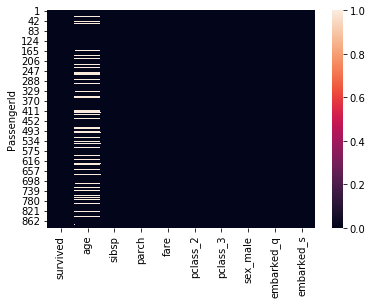

In [64]:
# find null values
nuns = passengers_1.isnull()

# create heat map
sns.heatmap(nuns)

Apparently we need to backfill age. I can use the median, or I can use the median based on other indicators. I like the idea of using `sibsp` and `parch`, because these would tell you if this is a kid traveling with a family or not.

In [65]:
medians = passengers_1.groupby(['sibsp','parch']).agg({
    'age': np.median
})

medians

age
sibsp parch      
0     0      29.5
      1      27.0
      2      20.5
      3      24.0
      4      29.0
      5      40.0
1     0      30.0
      1      30.5
      2      24.0
      3      48.0
      4      45.0
      5      39.0
      6      43.0
2     0      28.0
      1       4.0
      2      19.5
      3      24.0
3     0      31.5
      1       3.0
      2      10.0
4     1       7.0
      2       6.0
5     2      11.0
8     2       NaN

In [66]:
# fill the nulls on medians with the overall median
medians = medians.fillna(passengers_1['age'].median())

In [89]:
# add the medians the data
medians = medians.rename(columns={'age':'median'})
passengers_2 = passengers_1.merge(
    medians,
    how='left',
    left_on=['sibsp','parch'],
    right_index=True
)      
    
passengers_2['age'] = np.where(
    passengers_2['age'].isnull(),
    passengers_2['median'],
    passengers_2['age']
)

passengers_2[passengers_2['age'].isnull()].shape

(0, 11)

# run initial model to see if it works

In [91]:
# split the data for training and testing
x = passengers_2.drop('survived',axis=1)
y = passengers_2['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# train the model
model = LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [92]:
predictions = model.predict(x_test)

print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.78      0.86      0.82       106
          1       0.76      0.66      0.71        73

avg / total       0.78      0.78      0.77       179



This is not a very good model. Let's see if I can include more data from the columns I originally excluded.